In [1]:
# # Mounting to google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# %cd /content/gdrive/My Drive/ERA - Phase I/Session 18/VAE/

In [3]:
# ! pip install pytorch_lightning

In [4]:
# ! pip install lightning-bolts

In [5]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F

from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import numpy as np
import random
import cv2
import os
import matplotlib.pyplot as plt

/home/user/miniconda3/envs/test/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/user/miniconda3/envs/test/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/user/miniconda3/envs/test/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/user/miniconda3/envs/test/lib/python3.11/site-packages/pl_

In [6]:
from torchvision import datasets

class Cifar10SearchDataset(torchvision.datasets.CIFAR10):

    def __init__(self, root="./data", train=True, download=True, transform=None):
      super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
      image, label = self.data[index], self.targets[index]

      if self.transform is not None:
        transformed = self.transform(image=image)
        image = transformed["image"]

        return image, label

In [7]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

mu_cifar = (0.49139968, 0.48215827, 0.44653124)
sigma_cifar = (0.24703233, 0.24348505, 0.26158768)

def augmentation(data, mu=mu_cifar, sigma=sigma_cifar, pad=4):
    if data == 'Train':
        transform = A.Compose([A.HorizontalFlip(p=0.5),
                            A.Normalize(mean=mu, std=sigma),
                            ToTensorV2()])
    elif data == 'Test':
        transform = A.Compose([A.Normalize(mean=mu_cifar, std=sigma_cifar),
                           ToTensorV2()])
    else:
        transform = A.Compose([ToTensorV2()])

    return transform

In [8]:
def num_to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

def categorical_to_num(y):
  """ Decodes a 1-hot encoding """
  return np.argmax(y)

In [9]:
# Dataset is there to be able to interact with DataLoader
from torch.utils.data import Dataset

class cifar10_data(Dataset):
  '''
  cifar10_data class to create an iteratable on our custom cifar10 dataset:
  where data = (image and image label as one-hot-encoding) and labels = (image)
  '''

  def __init__(self, d):
    self.cifar = d                                                              # Initialize with cifar data object

  def __getitem__(self, index):

    image, label = self.cifar[index]
    number_encoding = num_to_categorical(label, 10)                             # 1-hot encoding of number
    number_encoding = torch.tensor(number_encoding)

    return image, number_encoding                                               # (input), (output) to network

  def __len__(self):                                                            # Return the length of the dataset
    return len(self.cifar)

In [10]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes_dict = {c:idx for idx, c in enumerate(classes)}

In [11]:
BATCH_SIZE = 512

class VAE(pl.LightningModule):
    def __init__(self, data_dir, n_labels=10, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.data_dir = data_dir
        self.transform_train = augmentation('Train')
        self.transform_valid = augmentation('Test')
        self.n_labels = n_labels
        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim+self.n_labels, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim+self.n_labels, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, label = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)

        mu, log_var = self.fc_mu(torch.cat((x_encoded, label), dim=1)), self.fc_var(torch.cat((x_encoded, label), dim=1))

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

    def prepare_data(self):
        # download
        Cifar10SearchDataset(self.data_dir, train=True, download=True, transform=None)
        Cifar10SearchDataset(self.data_dir, train=False, download=True, transform=None)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            self.cifar_train = cifar10_data(Cifar10SearchDataset(self.data_dir, train=True, download=False, transform=self.transform_train))
            self.cifar_valid = cifar10_data(Cifar10SearchDataset(self.data_dir, train=False, download=False, transform=self.transform_valid))

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.cifar_test = cifar10_data(Cifar10SearchDataset(self.data_dir, train=False, download=False, transform=self.transform_valid))

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

    def val_dataloader(self):
        return DataLoader(self.cifar_valid, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=BATCH_SIZE, num_workers=os.cpu_count())


In [12]:
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelSummary

In [13]:
epochs = 50
num_classes=10
learning_rate=1e-4

model = VAE('.')
trainer = Trainer(
    callbacks=[ModelSummary(max_depth=-1)],
    gpus=[1],
    max_epochs = epochs,
    )
trainer.fit(model)

/tmp/ipykernel_318456/1558022109.py:14: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/home/user/miniconda3/envs/test/lib/python3.11/site-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/home/user/miniconda3/envs/test/lib/python3.11/site-packages/pl_bolts

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

    | Name                          | Type              | Params
----------------------------------------------------------------------
0   | encoder                       | ResNetEncoder     | 11.2 M
1   | encoder.conv1                 | Conv2d            | 1.7 K 
2   | encoder.bn1                   | BatchNorm2d       | 128   
3   | encoder.relu                  | ReLU              | 0     
4   | encoder.maxpool               | MaxPool2d         | 0     
5   | encoder.layer1                | Sequential        | 147 K 
6   | encoder.layer1.0              | EncoderBlock      | 74.0 K
7   | e

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [14]:
torch.save(model.state_dict(), 'results/CIFAR10_pl.pth')

# Prediction: Image with wrong number

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")                            # assigning gpu to variable device

In [16]:
test_set = Cifar10SearchDataset(train=False, download=True, transform=augmentation('Test'))
test_set_custom = cifar10_data(test_set) 

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

test_loader = torch.utils.data.DataLoader(
    test_set_custom,
    batch_size = BATCH_SIZE,
    shuffle=True, 
    **kwargs
)

Files already downloaded and verified


In [17]:
def model_call(model, input1, input2):

    with torch.no_grad():

        encoded_image = model.encoder(input1)
        linear_layer = torch.cat((encoded_image, input2), dim=1) 
        mu, log_var = model.fc_mu(linear_layer), model.fc_var(linear_layer)

        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        decoded_image = model.decoder(z).to('cpu') 

        return decoded_image

In [45]:
count = 0 
all_predictions_wrong = []
all_predictions_correct = []
all_labels = []

for data, label in test_loader:

    r_idx = random.randrange(0, 256)

    input = data[r_idx]
    gt = label[r_idx]

    correct_label = categorical_to_num(np.array(gt))

    while count < 25: 
        r_label = random.randrange(0, 10)
        if r_label != correct_label:
            wrong_label = r_label

            all_labels.append([correct_label, wrong_label])

            wrong_label_vector = num_to_categorical(wrong_label, 10)
            gt_mod = gt.clone()
            gt_mod = torch.tensor(wrong_label_vector)

            ## unqueeze to get batch dim
            input1 = input.unsqueeze(0)  
            input2 = gt.unsqueeze(0)
            input2_mod = gt_mod.unsqueeze(0) 

            # print(f'gt label {correct_label}, wrong label added {wrong_label}')

            prediction_correct = model_call(model.to(device), input1.to(device), input2.to(device)).detach().cpu().squeeze(0).squeeze(0)
            prediction_wrong = model_call(model.to(device), input1.to(device), input2_mod.to(device)).detach().cpu().squeeze(0).squeeze(0)

            all_predictions_correct.append(prediction_correct)
            all_predictions_wrong.append(prediction_wrong)

            count += 1 

    break

In [46]:
id2classes = {classes_dict[key]:key for key in classes_dict.keys()}

In [47]:
mu_cifar = (0.49139968, 0.48215827, 0.44653124)
sigma_cifar = (0.24703233, 0.24348505, 0.26158768)

In [53]:
def plot_grid(image, labels, noise=False):

    nrows = 5
    ncols = 5

    fig, ax = plt.subplots(nrows, ncols, figsize=(10, 10))

    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            ax[i, j].axis("off")
            img = torch.tensor(image[index]).permute(1, 2, 0).numpy()*sigma_cifar + mu_cifar
        
            ax[i, j].imshow(img)

            correct, wrong = labels[index]
            if noise:
                s = f'True: {id2classes[correct]}\nNoise: {id2classes[wrong]}'
                ax[i, j].text(0, 5, s, color='Black')
            else:
                s = f'True: {id2classes[correct]}'
                ax[i, j].text(0, 2, s, color='Black')

    plt.subplots_adjust(wspace=0, hspace=0.01)


/tmp/ipykernel_318456/2262687867.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image[index]).permute(1, 2, 0).numpy()*sigma_cifar + mu_cifar
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data t

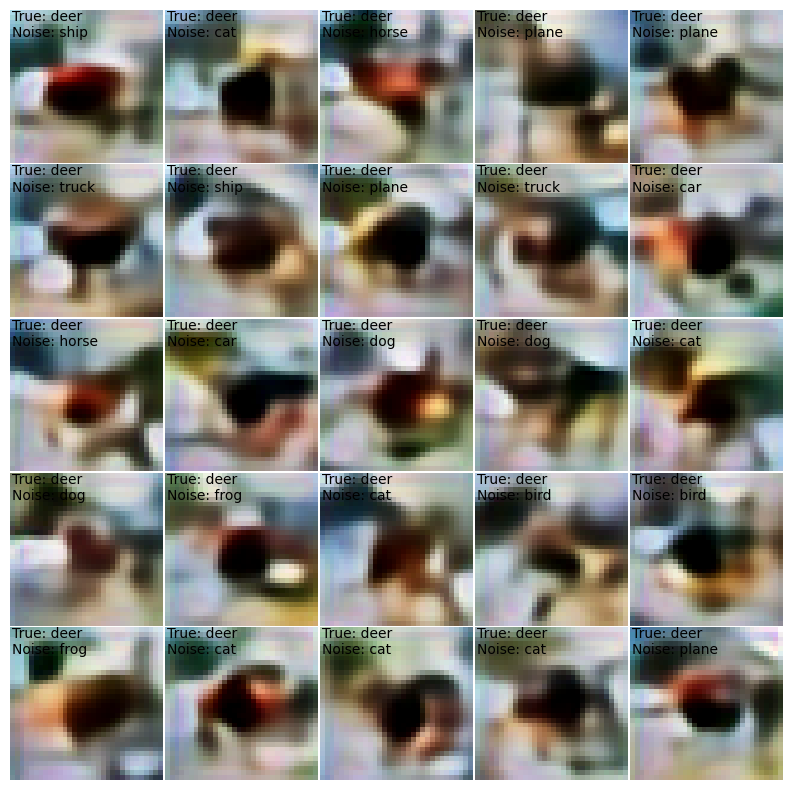

In [54]:
plot_grid(all_predictions_wrong, all_labels, True)

In [52]:
# plot_grid(all_predictions_correct, all_labels, True)